First we need to intall some codes needed to run the example. You have to have some patiance here as it takes some time to prepare everything. 



In [ ]:
%%capture
!apt install subversion
!svn checkout 
!pip install ase

In [ ]:
%%capture
!pip install git+https://github.com/yqshao/ase-notebook.git
!pip install pythreejs

In [ ]:
%%capture
from google.colab import output
from ase_notebook import AseView, ViewConfig, get_example_atoms


config = ViewConfig()
ase_view = AseView(config)
ase_view = AseView(
    rotations="45x,45y,45z",
    atom_font_size=16,
    axes_length=30,
    canvas_size=(400, 400),
    zoom=1.2,
    show_bonds=True
)
ase_view.config.uc_dash_pattern=(.6,.4)
# ase_view.add_miller_plane(
#     1, 0, 0, color="green")
ase_view.config
ViewConfig(rotations='45x,45y,45z', element_colors='ase', element_radii='ase', radii_scale=0.89, atom_show_label=True, atom_label_by='element', atom_label_array='', atom_font_size=16, atom_font_color='black', atom_stroke_width=1.0, atom_stroke_opacity=0.95, atom_color_by='element', atom_color_array='', atom_colormap='jet', atom_colormap_range=(None, None), atom_lighten_by_depth=0.0, atom_opacity=0.95, force_vector_scale=1.0, velocity_vector_scale=1.0, ghost_stroke_width=0.0, ghost_lighten=0.0, ghost_opacity=0.4, ghost_stroke_opacity=0.4, ghost_show_label=False, ghost_cross_out=False, show_unit_cell=True, show_uc_repeats=False, uc_dash_pattern=(0.6, 0.4), uc_color='black', show_bonds=True, bond_radii_scale=1.5, bond_array_name=None, bond_pairs_filter=None, bond_opacity=0.8, bond_color_by='atoms', bond_colormap='jet', bond_colormap_range=(None, None), show_miller_planes=True, miller_planes=({'h': 1, 'k': 0, 'l': 0, 'fill_color': 'green', 'stroke_color': 'green', 'stroke_width': 1, 'fill_opacity': 0.5, 'stroke_opacity': 0.9},), miller_as_lines=False, show_axes=True, axes_uc=False, axes_length=30, axes_font_size=14, axes_line_color='black', axes_offset=(20, 20), canvas_size=(400, 400), canvas_color_foreground='#000000', canvas_color_background='#ffffff', canvas_background_opacity=0.0, canvas_crop=None, zoom=1.2, camera_fov=10.0, gui_swap_mouse=False)

ase_view.config.canvas_color_background = "blue"
ase_view.config.canvas_background_opacity = 0.2
ase_view.config.atom_show_label = False



# Building something
Please free to explore the various ways to build things with ASE.

In [ ]:
from ase.build import fcc111,fcc110,fcc100
from ase.build import bulk
from ase.visualize import view
from ase.calculators.emt import EMT
from ase.optimize import QuasiNewton

atoms=bulk('Ag','fcc',a=4.1) #Build a pease of bulk
atoms=atoms*[3,3,3]          #Make a 3x3x3 supercell
del atoms[4]                 #Delete an atom
atoms.symbols[5]='Au'        #Replace an atom

In [ ]:
#VISUALIZATION
gui = ase_view.make_render(
    atoms, center_in_uc=True,create_gui=False)
gui

### Geometry optimization
More details: https://wiki.fysik.dtu.dk/ase/ase/optimize.html

In [ ]:
from ase.build import fcc111,fcc110,fcc100
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.optimize import QuasiNewton

def get_max_F(atoms):
  return np.max(np.linalg.norm(atoms.get_forces()  ))

calc=EMT()

#The EMT potential is an approximation to DFT. We use it here only to save time! 
#If you need to perform a "real" simulation you replace EMT with DFT, and wait patiently for the result! 
# You could use e.g.  ag.calc = GPAW(xc='PBE', mode=PW(300), txt='ag.txt')
# However, you need to install gpaw to do so...


#THIS WAY CAN BUILD A SLAB: More details: https://wiki.fysik.dtu.dk/ase/ase/build/surface.html
Al_slab = fcc110('Ag', size=(3,3,10), vacuum=10.0) 
Al_bulk = bulk('Ag','fcc')

Al_bulk.calc=calc
Al_slab.calc=calc


#This is how you set up an geometry optimization. More details: https://wiki.fysik.dtu.dk/ase/ase/optimize.html
dyn = QuasiNewton(Al_slab)
dyn.run(fmax=0.01)

gui = ase_view.make_render(
    Al_slab, center_in_uc=True,create_gui=False)
gui

In [ ]:
#BUILD YOU OWN OPTIMIZER USING A STEEPEST DESCENT

#Here should find the following commande very useful
#Note that ASE units for forces and postions are eV/Å and Å, respectively.
F=Al_slab.get_forces()    # Calculate the current forces acting of each atom. 3xN list with Fx,Fy,Fz. https://wiki.fysik.dtu.dk/ase/ase/atoms.html#ase.Atoms.get_forces
Al_slab.positions += F*10 # Update positions by "moving" each atom a lenght corresponding to 10 times the magnitude of the force


#Rebuild the slab so that you can compare your optimization to the ASE implementaion above
Al_slab = fcc110('Ag', size=(3,3,10), vacuum=10.0)
Al_slab.calc=calc

#Implement your optimizer here:


### Estimating equlibrium volume and bulkmodules of simple solids.
More details here: https://wiki.fysik.dtu.dk/ase/tutorials/eos/eos.html[link text](https://)

100.1418924197602 GPa


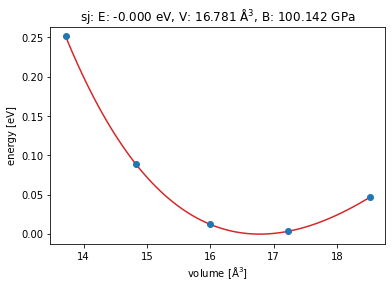

In [ ]:
import numpy as np

from ase import Atoms
from ase.io.trajectory import Trajectory
from ase.calculators.emt import EMT
from ase.units import kJ
from ase.eos import EquationOfState

volumes=[]
energies=[]
a = 4.0  # approximate lattice constant
b = a / 2
ag = Atoms('Ag',
           cell=[(0, b, b), (b, 0, b), (b, b, 0)],
           pbc=1,
           calculator=EMT())  # use EMT potential

cell = ag.get_cell()

for x in np.linspace(0.95, 1.05, 5):
    ag.set_cell(cell * x, scale_atoms=True)
    ag.get_potential_energy()
    volumes.append(ag.get_volume() )
    energies.append(ag.get_potential_energy())


# CALCULATING CELL VOLUME USING EOS: https://en.wikipedia.org/wiki/Birch%E2%80%93Murnaghan_equation_of_state
# Calculated E,V data can be used to make a fit and to find equlibrium energy, E0, equlibrium volume, V0 and Bulkmodulus B.

eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B / kJ * 1.0e24, 'GPa')

eos.plot("eos.png")

# WHAT IS THE OPTIMAL LATTICE CONSTANT?


In [ ]:
from google.colab import files
files.download('eos.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>